# PHASE RESPONSE CA3

We will test the phase response of neurons firing at a fixed rate. To test this, we will make a network of 100 HH neurons, which are going to be stimulated with a fixed input current, that forces them to produce spikes steadily. Then, we will stimulate them in different times and record the delays between the inter-spike intervals.

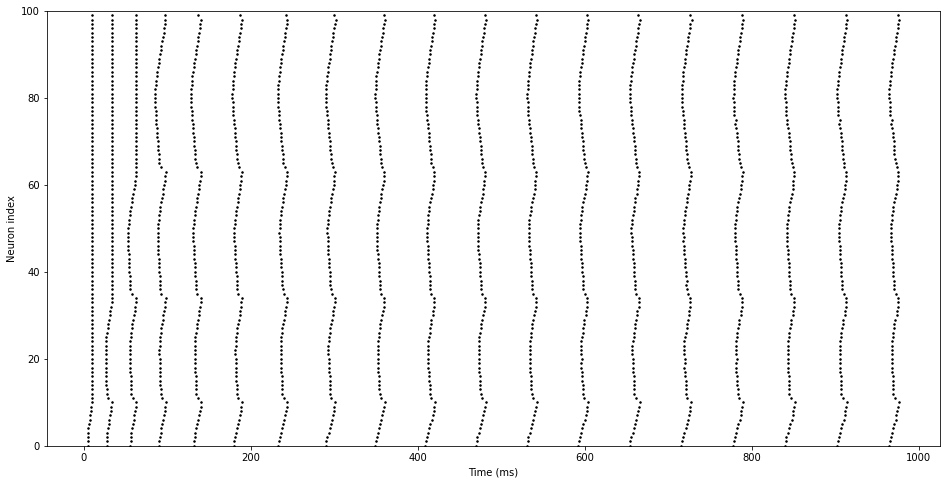

In [47]:
# Import brian2
from brian2 import *

# HH equations
# Pyramidal CAN
py_CAN_inp_eqs = '''
    dv/dt = (- I_CAN - I_M - I_leak - I_K - I_Na - I_Ca + I_exc + I_stim) / ((1.*ufarad*cm**-2) * (size)) + noise: volt
    I_CAN = ((gCAN) * (size)) * mCAN**2 * (v + 20.*mV) : amp
        dmCAN/dt = (mCANInf - mCAN) / mCANTau : 1
            mCANInf = alpha2 / (alpha2 + (0.0002*ms**-1)) : 1
            mCANTau = 1. / (alpha2 + (0.0002*ms**-1)) / (3.0**((36. - 22.) / 10.)) : second
            alpha2 = (0.0002*ms**-1) * (Ca_i / (5e-4*mole*metre**-3))**2 : Hz
    I_M = ((gM) * (size)) * p * (v - Ek) : amp
        dp/dt = (pInf - p) / pTau : 1
            pInf = 1. / (1. + exp(- (v + 35.*mV) / (10.*mV))) : 1
            pTau = (1000.*ms) / (3.3 * exp((v + 35.*mV) / (20.*mV)) + exp(- (v + 35.*mV) / (20.*mV))) : second
    I_leak = ((1e-5*siemens*cm**-2) * (size)) * (v - (-70.*mV)) : amp
    I_K = ((5*msiemens*cm**-2) * (size)) * (n**4) * (v - Ek) : amp
        dn/dt = alphan * (1 - n) - betan * n : 1
            alphan = 0.032 * (mV**-1) * (5.*mV) / exprel(-(v + 40.*mV) / (5.*mV)) / ms : Hz
            betan = 0.5 * exp(- (v + 45.*mV) / (40.*mV)) / ms : Hz
    I_Na = ((50*msiemens*cm**-2) * (size)) * (m**3) * h * (v - 50.*mV) : amp
        dm/dt = alpham * (1 - m) - betam * m : 1
            alpham = 0.32 * (mV**-1) * (4.*mV) / exprel(-(v + 42.*mV) / (4.*mV)) / ms : Hz
            betam = 0.28 * (mV**-1) * (5.*mV) / exprel( (v + 15.*mV) / (5.*mV)) / ms : Hz
        dh/dt = alphah * (1 - h) - betah * h : 1
            alphah = 0.128 * exp(- (v + 38.*mV) / (18.*mV)) / ms : Hz
            betah = 4. / (1. + exp(- (v + 15.*mV) / (5.*mV))) / ms : Hz
    I_Ca = ((1e-4 * siemens*cm**-2) * (size)) * (mCaL**2) * hCaL * (v - 120.*mV) : amp
        dmCaL/dt = (alphamCaL * (1. - mCaL)) - (betamCaL * mCaL) : 1
            alphamCaL = 0.055 * (mV**-1) * (3.8*mV) / exprel(-(v + 27.*mV) / (3.8*mV)) / ms : Hz
            betamCaL = 0.94 * exp(-(v + 75.*mV) / (17.*mV)) / ms : Hz
        dhCaL/dt = (alphahCaL * (1. - hCaL)) - (betahCaL * hCaL) : 1
            alphahCaL = 0.000457 * exp(-(v + 13.*mV) / (50.*mV)) / ms : Hz
            betahCaL = 0.0065 / (exp(-(v + 15.*mV) / (28.*mV)) + 1.) / ms : Hz
        dCa_i/dt = driveChannel + ((2.4e-4*mole*metre**-3) - Ca_i) / (200.*ms) : mole*meter**-3
            driveChannel = (-(1e4) * I_Ca / (cm**2)) / (2. * (96489*coulomb*mole**-1) * (1*umetre)) : mole*meter**-3*Hz

    dCl/dt = - Cl / tau_Cl : 1
    

    noise = sigma_noise_exc * (2. * (0.1e-3*siemens) / (1.*ufarad))**.5 * randn() / sqrt(tstep) : volt/second (shared, constant over dt)


    I_exc : amp
    r : 1
    I_stim = inputs_stim(t-i*10*tstep) : amp
    size : metre**2 (shared)
'''

# Spike and reset
reset_eqs = '''
    Cl = Cl + 0.2
'''

# Simulation
duration = 1*second
dt = 0.1*ms
defaultclock.dt = dt


# Model parameters
tau_Cl = 0.1*second # removal rate of chloride ions in excitatory cells; healthy 0.1s
Ek = -100.*mV # resting potential of potassium channels in excitatory cells; healthy -100mV
gM = 90.*usiemens*cmetre**-2 # conductance for M-current
gCAN = 0.25*usiemens*cmeter**-2 # wakefulness -> table 3.6, page 59, Aussel
cell_size_py = 29.e3*umetre**2
sigma_noise_exc = 0* 100.*uvolt # NOISE OFF
tstep = defaultclock.dt
V_th = -20.*mvolt # spiking threshold
refractory_time = 3.*ms # refractory time after a spike


# Make a group of neurons
G = NeuronGroup(N=100,
    model=py_CAN_inp_eqs,
    threshold='v>V_th',
    reset=reset_eqs,
    refractory=refractory_time,
    method='exponential_euler',
    name='E_pyCAN')
G.size = cell_size_py
G.v = -60.*mV
G.I_exc = .5*nA


# Make the input
inputs_array = zeros((100,1))
inputs_stim = TimedArray([0., 5., 5., 5., 5., 5., 0.]*nA, dt=tstep)

# Create monitors
Mv = StateMonitor(G, 'v', record=True)
Ms = SpikeMonitor(G)


# Make the network
net = Network()
net.add(G, Mv, Ms)


# Test the network
net.run(1*second)

# Plotting
fig = figure(figsize=(16,8))
plot(Ms.t/ms, Ms.i, '.k', ms=3)
ylim(0, 100)
xlabel('Time (ms)')
ylabel('Neuron index');